In [1]:
import pandas as pd

df = pd.read_csv('/Users/minwoo/Desktop/취준/data_engineering_course_materials/missions/W2/21_reviews_score.csv')
df['label'] = df['star'].apply(lambda x: 1 if x == 5.0 else 0)
df = df[['review', 'label']].dropna()
df.head()

,review,label
0,바로 파데하고 찍은 사진 15시간 후 사진첫 파데를 이걸로 썼는데 다른 거 도전 안...,1
1,요건 그냥 무난무난 원래는 별루였는데 여름이라 그런지 최고의 파데임 워터루프도 아닌...,1
2,커버력은 있으면서도 밀착력있게 발리는거 같아요 색도 이뻐서 마음에 들어요 !!,1
3,몇년째 사용중인 제품이에요ㅎ파운데이션 중에 끈적이지않고 발색도 좋아요하나 더 쟁여 ...,1
4,1바르기전 2번 바른 후조금만 발랐는데도 밝아진게 확 느껴져요근데 처음에 발랐을땐 ...,0


In [2]:
df["label"].value_counts()

label
1    868
0    132
Name: count, dtype: int64

In [3]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base-v2022")
model = AutoModel.from_pretrained("beomi/KcELECTRA-base-v2022", output_attentions=True)
model.eval()

/opt/anaconda3/envs/W2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(54343, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0-11): 12 x ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0

In [4]:
import re
import emoji
from soynlp.normalizer import repeat_normalize

emojis = ''.join(emoji.EMOJI_DATA)
pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣{emojis}]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

import re
import emoji
from soynlp.normalizer import repeat_normalize

pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

def clean(x): 
    x = pattern.sub(' ', x)
    x = emoji.replace_emoji(x, replace='') #emoji 삭제
    x = url_pattern.sub('', x)
    x = x.strip()
    x = repeat_normalize(x, num_repeats=2)
    return x

In [ ]:
from kiwipiepy import Kiwi
import re

kiwi = Kiwi(typos='basic_with_continual')

def is_valid_token(form):
    return bool(re.fullmatch(r'[가-힣]+', form))

def extract_smart_nouns(text, min_len=2):
    result = []
    tokens = kiwi.tokenize(text, split_complex=True, normalize_coda=False)

    temp = ""
    temp_count = 0
    last_tag = None
    last_end = 0

    for token in tokens:
        form, tag = token.form, token.tag
        start, length = token.start, token.len

        is_space_between = start > last_end and text[last_end:start].isspace()
        last_end = start + length

        # 한글만 필터링
        if not re.fullmatch(r"[가-힣]+", form):
            continue

        # 공백이 있거나 너무 많이 붙었으면 현재까지는 종료
        if is_space_between or temp_count >= 2:
            if len(temp) >= min_len:
                result.append(temp)
            temp = ""
            temp_count = 0
            last_tag = None

        # NNG는 시작 또는 연결 대상
        if tag == 'NNG':
            if temp_count == 0:
                temp = form
                temp_count = 1
            elif last_tag == 'NNG':
                temp += form
                temp_count += 1
            else:
                if len(temp) >= min_len:
                    result.append(temp)
                temp = form
                temp_count = 1
            last_tag = tag

        # 접미사 XSN는 NNG 다음일 때만 붙임
        elif tag == 'XSN':
            if last_tag == 'NNG' and temp_count == 1:
                temp += form
                temp_count += 1
                last_tag = tag
            else:
                if len(temp) >= min_len:
                    result.append(temp)
                temp = ""
                temp_count = 0
                last_tag = None

        # 그 외는 모두 종료
        else:
            if len(temp) >= min_len:
                result.append(temp)
            temp = ""
            temp_count = 0
            last_tag = None

    if len(temp) >= min_len:
        result.append(temp)

    return result

In [20]:
samples = [
    "맛도리",
    "지속력",
    "다크닝이",
    "달팽이",
    "한달 동안 만족하며 사용했습니다",
    "제 인생파데...학생시절부터 꾸준히사용했러요 좋습니댜",
    "갠차나요 잘쓰고잇어뇨 흡수력도 나쁘지않고 컬러감도 예뻐서 무너짐도 예쁘고 잘 사용중이에용"
]

for sent in samples:
    print(f"📝 입력 문장: {sent}")
    print(f"➡️ 추출 명사: {extract_smart_nouns(sent)}\n")

📝 입력 문장: 맛도리
➡️ 추출 명사: ['맛도리']

📝 입력 문장: 지속력
➡️ 추출 명사: ['지속력']

📝 입력 문장: 다크닝이
➡️ 추출 명사: []

📝 입력 문장: 달팽이
➡️ 추출 명사: ['달팽이']

📝 입력 문장: 한달 동안 만족하며 사용했습니다
➡️ 추출 명사: ['동안', '만족', '사용']

📝 입력 문장: 제 인생파데...학생시절부터 꾸준히사용했러요 좋습니댜
➡️ 추출 명사: ['인생', '학생시절', '꾸준히사용했러요', '좋습니댜']

📝 입력 문장: 갠차나요 잘쓰고잇어뇨 흡수력도 나쁘지않고 컬러감도 예뻐서 무너짐도 예쁘고 잘 사용중이에용
➡️ 추출 명사: ['흡수력', '컬러감', '사용']



In [18]:
kiwi.tokenize("꾸준히사용했러요")

[Token(form='꾸준히', tag='MAG', start=0, len=3),
 Token(form='사용', tag='NNG', start=3, len=2),
 Token(form='하', tag='XSV', start=5, len=1),
 Token(form='었', tag='EP', start=5, len=1),
 Token(form='러요', tag='EF', start=6, len=2)]

In [106]:
def extract_top_attention_words(text, tokenizer, model, noun_candidates, top_k=3):
    """
    주어진 명사 후보들 중 attention이 가장 높은 top_k 단어를 리스트로 반환
    """
    tokens = tokenizer(text, return_tensors='pt', truncation=True, max_length=64)
    input_ids = tokens['input_ids']
    
    with torch.no_grad():
        outputs = model(**tokens)
        attentions = outputs.attentions

    last_layer_attention = attentions[-1][0]  # (heads, seq, seq)
    mean_attention = last_layer_attention.mean(dim=0)  # (seq, seq)
    cls_attention = mean_attention[0]

    tokens_decoded = tokenizer.convert_ids_to_tokens(input_ids[0])
    attention_scores = []

    for token, score in zip(tokens_decoded, cls_attention):
        token_clean = token.replace("##", "")
        if token in ["[CLS]", "[SEP]"] or token.startswith("##"):
            continue
        if token_clean in noun_candidates:
            attention_scores.append((token_clean, score.item()))

    # 중요도 순 정렬 후 top_k만 반환
    if attention_scores:
        attention_scores.sort(key=lambda x: -x[1])
        top_words = [word for word, _ in attention_scores[:top_k]]
        return top_words
    else:
        return []

In [107]:
from collections import defaultdict
from tqdm import tqdm

positive_words = defaultdict(float)
negative_words = defaultdict(float)

top_k = 3 # 추출할 키워드 개수

for _, row in tqdm(df.iterrows(), total=len(df)):
    text = clean(row['review'])
    label = row['label']

    noun_candidates = extract_smart_nouns(text)
    if not noun_candidates:
        continue
    
    keywords = extract_top_attention_words(text, tokenizer, model, noun_candidates, top_k=top_k)
    if not keywords:
        continue

    for kw in keywords:
        if label == 1:
            positive_words[kw] += 1
        else:
            negative_words[kw] += 1

100%|██████████| 1000/1000 [00:41<00:00, 24.06it/s]


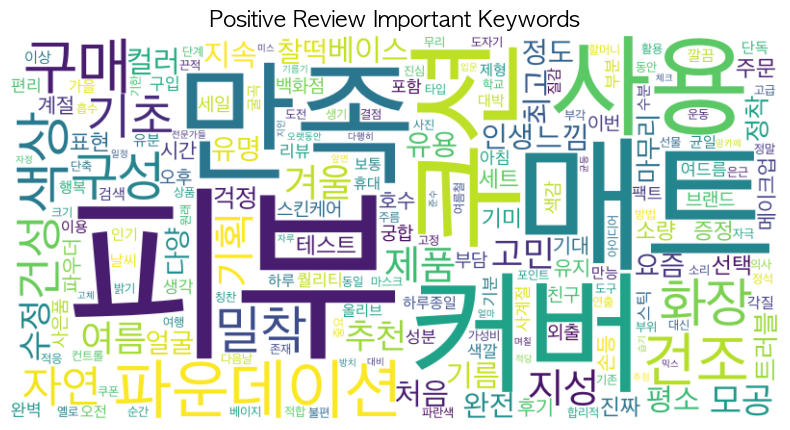

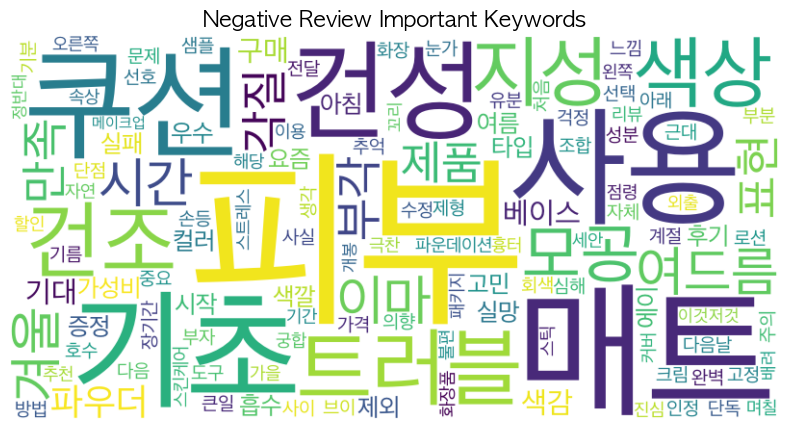

In [108]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def draw_wordcloud(freq_dict, title):
    wc = WordCloud(
        font_path='/System/Library/Fonts/AppleSDGothicNeo.ttc',
        background_color='white',
        width=800, height=400
    ).generate_from_frequencies(freq_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

draw_wordcloud(positive_words, "Positive Review Important Keywords")
draw_wordcloud(negative_words, "Negative Review Important Keywords")

In [109]:
def get_top_k_noun_tokens(text, k=3):
    tokens = extract_smart_nouns(text)
    if tokens:
        freq = defaultdict(int)
        for t in tokens:
            freq[t] += 1
        sorted_tokens = sorted(freq.items(), key=lambda x: -x[1])
        return [word for word, _ in sorted_tokens[:k]]
    return []

# 키워드 컬럼 생성
df['keyword'] = df['review'].apply(get_top_k_noun_tokens)

# 결과 테이블 미리보기
df_keyword_table = df[['review', 'label', 'keyword']]
df_keyword_table.head()


,review,label,keyword
0,바로 파데하고 찍은 사진 15시간 후 사진첫 파데를 이걸로 썼는데 다른 거 도전 안...,1,"[피부, 퍼프, 파데]"
1,요건 그냥 무난무난 원래는 별루였는데 여름이라 그런지 최고의 파데임 워터루프도 아닌...,1,"[난무, 원래, 여름]"
2,커버력은 있으면서도 밀착력있게 발리는거 같아요 색도 이뻐서 마음에 들어요 !!,1,"[커버력, 밀착력, 마음]"
3,몇년째 사용중인 제품이에요ㅎ파운데이션 중에 끈적이지않고 발색도 좋아요하나 더 쟁여 ...,1,"[사용, 제품, 파운데이션]"
4,1바르기전 2번 바른 후조금만 발랐는데도 밝아진게 확 느껴져요근데 처음에 발랐을땐 ...,0,"[후조금, 처음, 지속력]"


In [110]:
output_path = "/Users/minwoo/Desktop/취준/data_engineering_course_materials/missions/W2/review_with_keywords.csv"
df_keyword_table.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"CSV 저장 완료: {output_path}")

CSV 저장 완료: /Users/minwoo/Desktop/취준/data_engineering_course_materials/missions/W2/review_with_keywords.csv


In [11]:
color_seed_words = [
    "색", "색상", "색깔", "컬러", "빨강", "노랑", "상아", "붉은", "누런", "노란", "붉은", "다크닝", "밝은", "어두운", "분홍", "핑크", "베이지", "옐로우", "톤",
    "핑베", "뉴트럴", "붉은기", "잡티", "쿨톤", "웜톤", "홍조", "화사", "브라이트", "속광", "은은", "뽀얗", "내추럴", "내츄럴", "자연", "다양", "뽀용",
    ]

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_token_embedding(token, tokenizer, model):
    tokens = tokenizer(token, return_tensors='pt')
    with torch.no_grad():
        output = model(**tokens)
    return output.last_hidden_state[0, 1].numpy()  # 첫 번째 실제 토큰 벡터 반환 ([CLS]는 제외)

# 1) 색 기준 벡터 계산
color_embeddings = []
for word in color_seed_words:
    emb = get_token_embedding(word, tokenizer, model)
    color_embeddings.append(emb)
color_matrix = np.stack(color_embeddings)

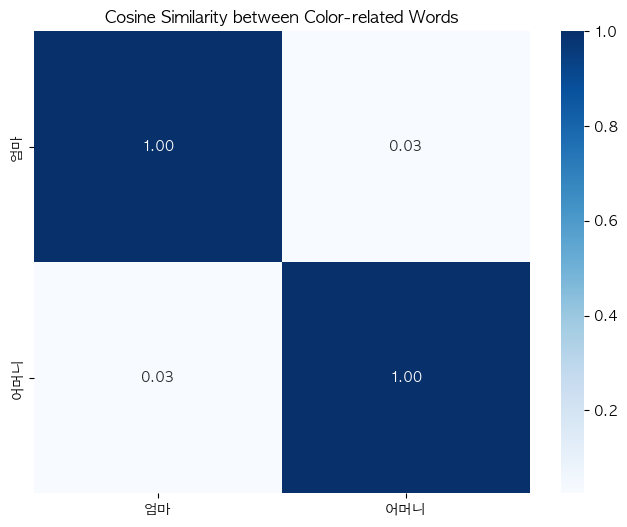

,엄마,어머니
엄마,1.000000,0.025168
어머니,0.025168,1.000000


In [28]:
import matplotlib
matplotlib.rc("font", family="AppleGothic")  # macOS
plt.rcParams['axes.unicode_minus'] = False

words = ["엄마", "어머니"]

# 단어 임베딩 추출 함수
def get_token_embedding(text, tokenizer, model, method="mean"):
    tokens = tokenizer(text, return_tensors='pt', truncation=True)
    with torch.no_grad():
        outputs = model(**tokens)

    if method == "mean":
        token_vecs = outputs.last_hidden_state[0][1:-1]  # [CLS] 제외
        return token_vecs.mean(dim=0).numpy()
    elif method == "cls":
        return outputs.last_hidden_state[0][0].numpy()

# 모든 단어 임베딩
embeddings = []
for word in words:
    try:
        emb = get_token_embedding(word, tokenizer, model)
        embeddings.append(emb)
    except Exception as e:
        print(f"❌ {word} 임베딩 실패:", e)
        embeddings.append(np.zeros(768))  # 예외 발생 시 0 벡터

# 코사인 유사도 행렬 계산
embedding_matrix = np.stack(embeddings)
similarity_matrix = cosine_similarity(embedding_matrix)

# 보기 좋게 출력
import pandas as pd
sim_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(sim_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("Cosine Similarity between Color-related Words")
plt.show()

# 테이블로 출력도 함께
sim_df

In [29]:
tokens = tokenizer.tokenize("엄마")
print(tokens)  # 잘게 쪼개졌는지 확인

tokens2 = tokenizer.tokenize("어머니")
print(tokens2)

['엄마']
['어머니']


In [39]:
def get_token_embedding(text, tokenizer, model):
    sent = f"{text} 는 가족 중 한명이다"  # 예시 문맥
    tokens = tokenizer(sent, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**tokens)

    token_ids = tokens['input_ids'][0]
    tokens_decoded = tokenizer.convert_ids_to_tokens(token_ids)
    
    # text가 포함된 subword들의 평균 구하기
    indices = [i for i, token in enumerate(tokens_decoded) if text in token]
    if not indices:
        return outputs.last_hidden_state[0][0].numpy()  # fallback: [CLS]
    
    vecs = outputs.last_hidden_state[0][indices]
    return vecs.mean(dim=0).numpy()

In [40]:
words = ["엄마", "어머니"]
contextualized_embeddings = [get_token_embedding(w, tokenizer, model) for w in words]

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
sim_matrix = cosine_similarity(contextualized_embeddings)
print(sim_matrix)

[[0.99999964 0.9766282 ]
 [0.9766282  1.0000001 ]]


In [34]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('ko.bin', binary=True)
model.similarity("엄마", "어머니")  # 0.89 정도 나올 수 있음

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [12]:
def extract_top_color_keywords(text, tokenizer, model, noun_candidates, top_k=5):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, max_length=64)
    input_ids = tokens['input_ids']

    with torch.no_grad():
        outputs = model(**tokens)
        attentions = outputs.attentions

    if attentions is None:
        return []

    last_layer_attention = attentions[-1][0]  # (heads, seq, seq)
    mean_attention = last_layer_attention.mean(dim=0)  # (seq, seq)
    cls_attention = mean_attention[0]

    tokens_decoded = tokenizer.convert_ids_to_tokens(input_ids[0])
    attention_scores = []

    for token, score in zip(tokens_decoded, cls_attention):
        token_clean = token.replace("##", "")
        if token in ["[CLS]", "[SEP]"] or token.startswith("##"):
            continue
        if token_clean in noun_candidates:
            attention_scores.append((token_clean, score.item()))

    # 1차 attention 기반 top-N 추출
    attention_scores.sort(key=lambda x: -x[1])
    top_attention_tokens = [word for word, _ in attention_scores[:20]]  # 넉넉하게 추출

    # 2차 색 유사도 필터링
    color_relevant_tokens = []
    for word in top_attention_tokens:
        try:
            word_emb = get_token_embedding(word, tokenizer, model).reshape(1, -1)
            sim = cosine_similarity(word_emb, color_matrix).max()
            if sim > 0.6:  # 임계값은 0.5~0.7 범위에서 조절
                color_relevant_tokens.append((word, sim))
        except:
            continue

    # 유사도 순 정렬
    color_relevant_tokens.sort(key=lambda x: -x[1])
    return [word for word, _ in color_relevant_tokens[:top_k]]

In [13]:
color_positive_words = defaultdict(float)
color_negative_words = defaultdict(float)

top_k = 3 # 추출할 키워드 개수

for _, row in tqdm(df.iterrows(), total=len(df)):
    text = clean(row['review'])
    label = row['label']

    noun_candidates = extract_nouns(text)
    if not noun_candidates:
        continue
    
    color_keywords = extract_top_color_keywords(text, tokenizer, model, noun_candidates, top_k=top_k)
    if not color_keywords:
        continue

    for kw in color_keywords:
        if label == 1:
            color_positive_words[kw] += 1
        else:
            color_negative_words[kw] += 1

100%|██████████| 1000/1000 [03:33<00:00,  4.69it/s]


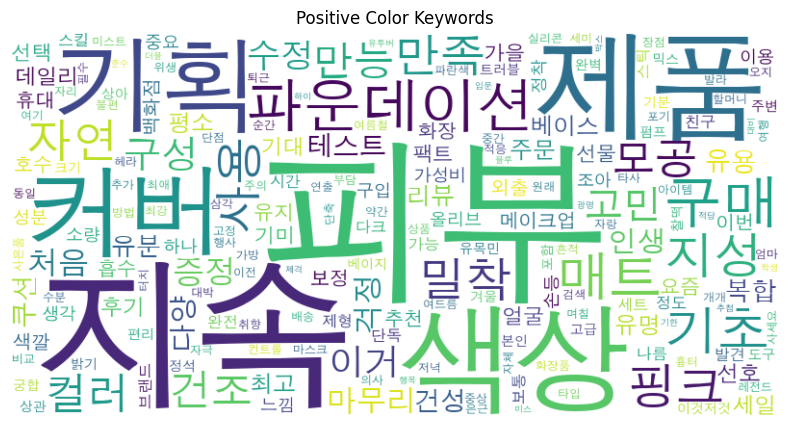

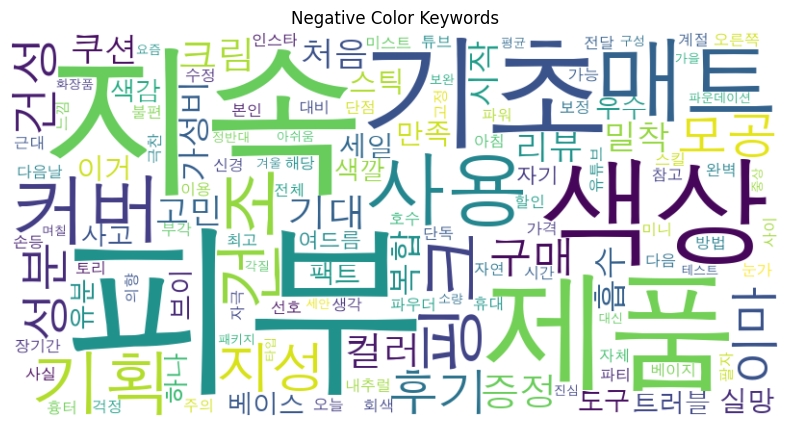

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(word_freq, title):
    wc = WordCloud(font_path='/Library/Fonts/AppleGothic.ttf', width=800, height=400, background_color='white')
    wc.generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wordcloud(color_positive_words, "Positive Color Keywords")
plot_wordcloud(color_negative_words, "Negative Color Keywords")

In [15]:
import pandas as pd

# dict ➝ dataframe 변환
df_color_pos = pd.DataFrame(color_positive_words.items(), columns=["keyword", "positive_count"])
df_color_neg = pd.DataFrame(color_negative_words.items(), columns=["keyword", "negative_count"])

# merge: 모든 키워드에 대해 양쪽 count 표시
df_color_summary = pd.merge(df_color_pos, df_color_neg, on='keyword', how='outer').fillna(0)

# 정수형 변환
df_color_summary['positive_count'] = df_color_summary['positive_count'].astype(int)
df_color_summary['negative_count'] = df_color_summary['negative_count'].astype(int)

# 총합 기준 정렬
df_color_summary['total'] = df_color_summary['positive_count'] + df_color_summary['negative_count']
df_color_summary = df_color_summary.sort_values(by='total', ascending=False)

df_color_summary.head()

,keyword,positive_count,negative_count,total
372,피부,236,31,267
310,지속,193,24,217
151,색상,95,12,107
291,제품,92,14,106
46,기획,70,7,77


In [16]:
def get_color_keywords_for_row(text, tokenizer, model, top_k=3):
    text_cleaned = clean(text)
    noun_candidates = extract_nouns(text_cleaned)
    if not noun_candidates:
        return []
    
    keywords = extract_top_color_keywords(text_cleaned, tokenizer, model, noun_candidates, top_k=top_k)
    return keywords if keywords else []

# 새 컬럼 추가: 리뷰별 색상 키워드 top-k 리스트
df['color_keyword'] = df['review'].apply(lambda x: get_color_keywords_for_row(x, tokenizer, model, top_k=3))

# 결과 테이블 구성
df_keyword_table = df[['review', 'label', 'color_keyword']]
df_keyword_table.head()

,review,label,color_keyword
0,바로 파데하고 찍은 사진 15시간 후 사진첫 파데를 이걸로 썼는데 다른 거 도전 안...,1,"[모공, 복합, 흉터]"
1,요건 그냥 무난무난 원래는 별루였는데 여름이라 그런지 최고의 파데임 워터루프도 아닌...,1,[원래]
2,커버력은 있으면서도 밀착력있게 발리는거 같아요 색도 이뻐서 마음에 들어요 !!,1,"[밀착, 커버]"
3,몇년째 사용중인 제품이에요ㅎ파운데이션 중에 끈적이지않고 발색도 좋아요하나 더 쟁여 ...,1,"[제품, 구매, 사용]"
4,1바르기전 2번 바른 후조금만 발랐는데도 밝아진게 확 느껴져요근데 처음에 발랐을땐 ...,0,"[고정, 지속, 파우더]"


In [17]:
df_keyword_table.to_csv("color_keywords_by_review.csv", index=False)